In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from io import StringIO
import numpy as np
from mlflux.gotm import read_ensem, read

%load_ext autoreload
%autoreload 3

In [23]:
n2 = 200 
start_date = pd.Timestamp('2012-05-21') 
folder = '/home/jw8736/test-gotm/ensem/2012-05-21_2012-08-20/'

n1 = 90*24*60 + 1 # 90 days 1 min
filename_mean = folder + 'out_test_min'
ds1 = read(filename_mean, n1, n2, start_date)

n1 = 90*24*6 + 1 # 90 days 10 min
filename_mean = folder + 'out_test_10min'
ds2 = read(filename_mean, n1, n2, start_date)

n1 = 90*24 + 1 # 90 days 1 hr
filename_mean = folder + 'out_test_hour'
ds3 = read(filename_mean, n1, n2, start_date)

In [2]:
n2 = 200 
start_date = pd.Timestamp('2012-08-21') 
folder = '/home/jw8736/test-gotm/ensem/2012-08-21_2013-01-10/'

# n1 = 140*24*60 + 1 # 90 days 1 min
# filename_mean = folder + 'out_1min'
# ds1 = read(filename_mean, n1, n2, start_date)

n1 = 140*24*6 + 1 # 90 days 10 min
filename_mean = folder + 'out_10min'
ds2 = read(filename_mean, n1, n2, start_date)

n1 = 140*24 + 1 # 90 days 1 hr
filename_mean = folder + 'out_60min'
ds3 = read(filename_mean, n1, n2, start_date)

n1 = 140*24 + 1 # 90 days 1 min
filename_mean = folder + 'out_bulk_hourly'
ds_kpp = read(filename_mean, n1, n2, start_date)

In [5]:
# ds1_hour = ds1.resample(t='H').mean()
ds2_hour = ds2.resample(t='H').mean()

Text(0.5, 1.0, '$difference$')

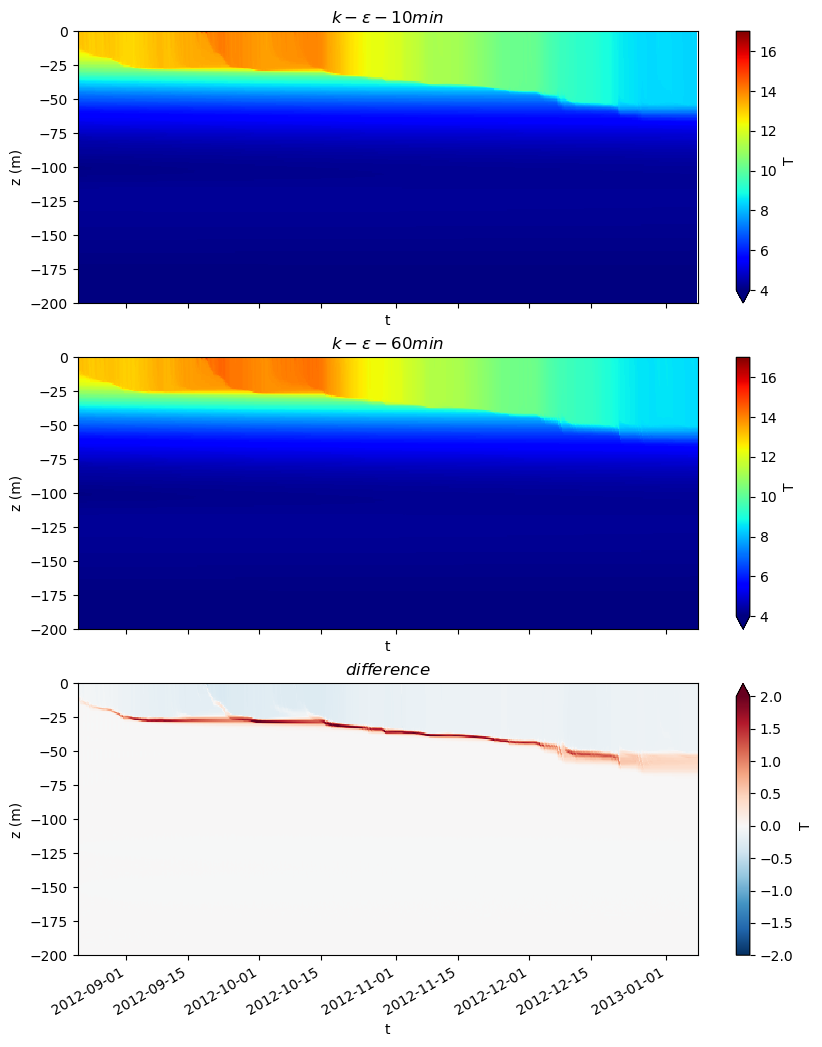

In [7]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12], sharex=True)

ds2['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'$k-\epsilon-10 min$')

ds3['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title(r'$k-\epsilon-60 min$')

(ds2_hour['T']-ds3['T']).plot.pcolormesh(ax=axes[2], x='t', y='z', vmin=-2, vmax=2, cmap='RdBu_r')
axes[2].set_ylabel('z (m)')
axes[2].set_title(r'$difference$')

Text(0.5, 1.0, '$difference$')

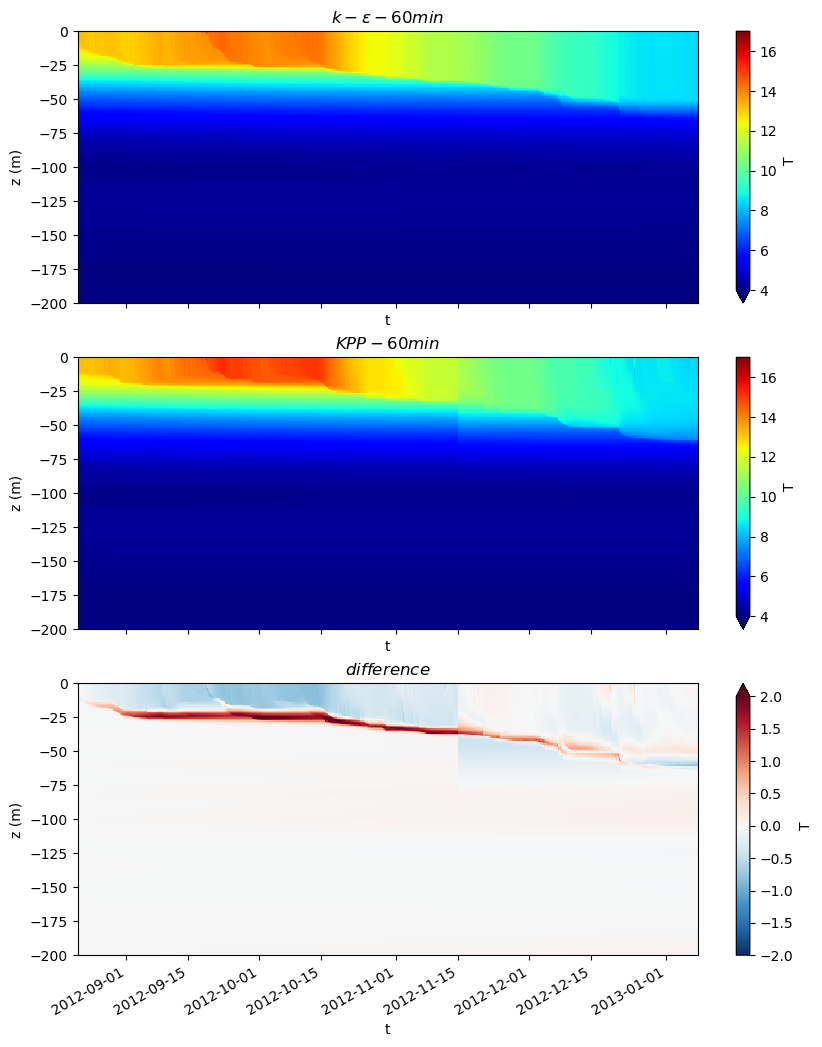

In [9]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12], sharex=True)

ds3['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'$k-\epsilon-60 min$')

ds_kpp['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title(r'$KPP-60 min$')

(ds3['T']-ds_kpp['T']).plot.pcolormesh(ax=axes[2], x='t', y='z', vmin=-2, vmax=2, cmap='RdBu_r')
axes[2].set_ylabel('z (m)')
axes[2].set_title(r'$difference$')

Text(0.5, 1.0, 'Daily minus 3-hourly')

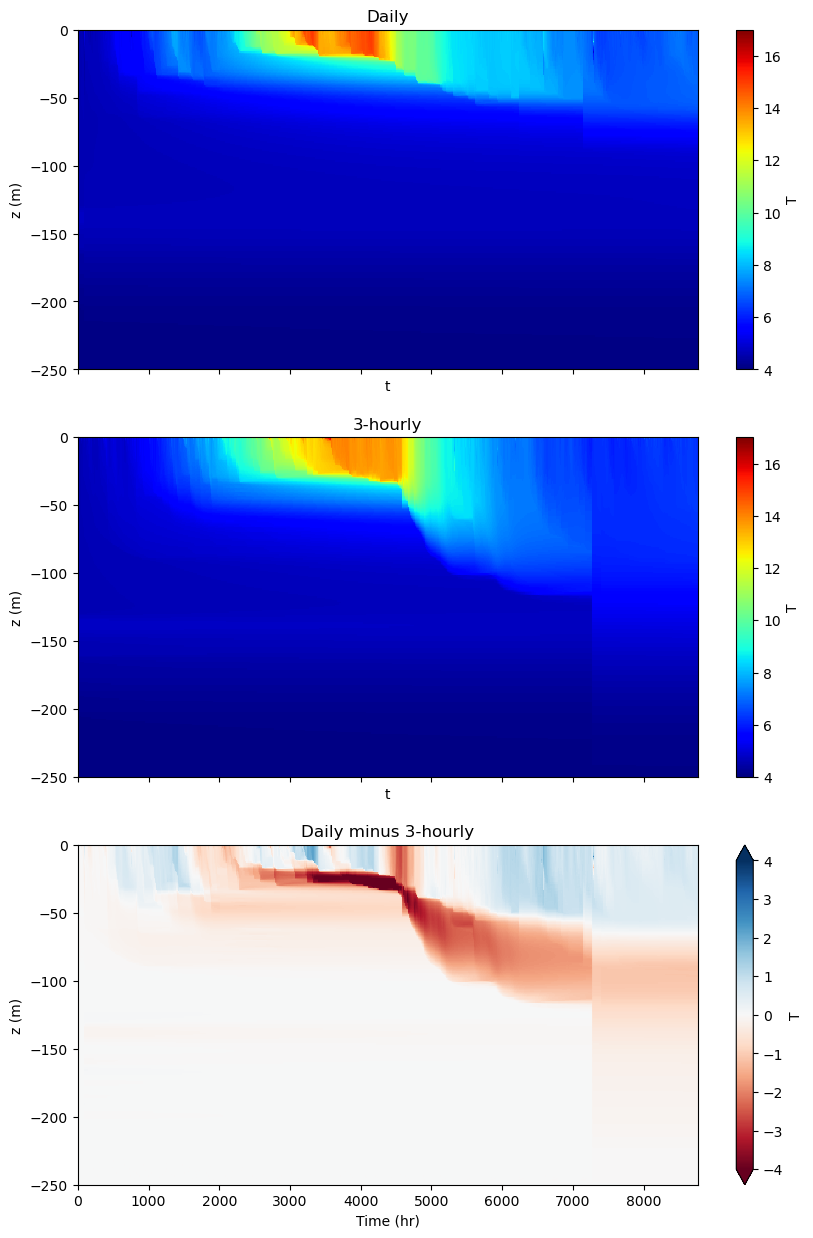

In [60]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,15], sharex=True)

df1 = make_ds('out_kpp_daily')
df1['T'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[0].set_ylabel('z (m)')
axes[0].set_title(r'Daily')
# axes[0].set_xlim([0,4000])

df2 = make_ds('out_kpp')
df2['T'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmin=4, vmax=17, cmap='jet')
axes[1].set_ylabel('z (m)')
axes[1].set_title('3-hourly')
# axes[1].set_xlim([0,4000])

df2_Tinterp = df2['T'].interp(t=df1.t, z=df1.z)
diff = df1['T']-df2_Tinterp
diff.plot.pcolormesh(ax=axes[2], x='t', y='z', vmin=-4, vmax=4, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'Daily minus 3-hourly')
# axes[2].set_xlim([0,4000])

Text(0.5, 1.0, '3-hourly minus daily')

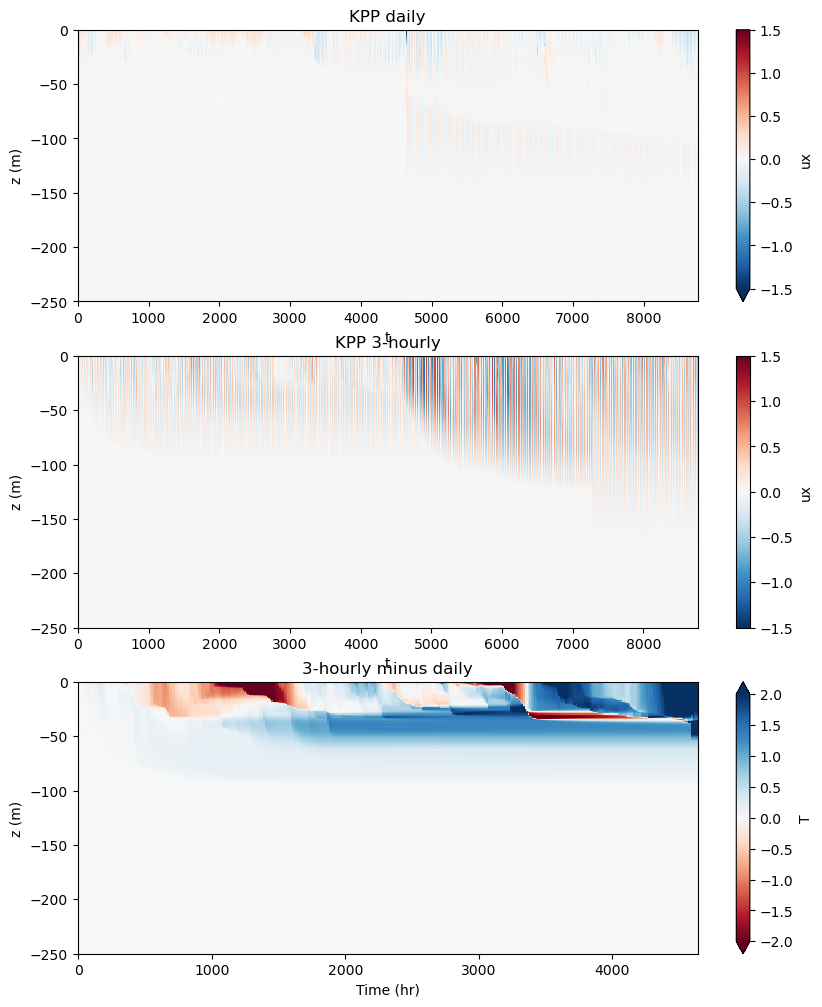

In [159]:
# xrdf['ux'].plot.pcolormesh(x='t',y='z')
fig, axes = plt.subplots(3, 1, figsize=[10,12])

df1 = make_ds('out_kpp_daily')
df1['ux'].plot.pcolormesh(ax=axes[0], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[0].set_ylabel('z (m)')
axes[0].set_title('KPP daily')

df2 = make_ds('out_kpp')
df2['ux'].plot.pcolormesh(ax=axes[1], x='t', y='z', vmax=1.5, vmin=-1.5, cmap='RdBu_r')
axes[1].set_ylabel('z (m)')
axes[1].set_title('KPP 3-hourly')

(df2['T']-df1['T']).plot.pcolormesh(ax=axes[2], x='t',y='z', vmin=-2, vmax=2, cmap='RdBu')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (hr)'); 
axes[2].set_title(r'3-hourly minus daily')


### ANNs

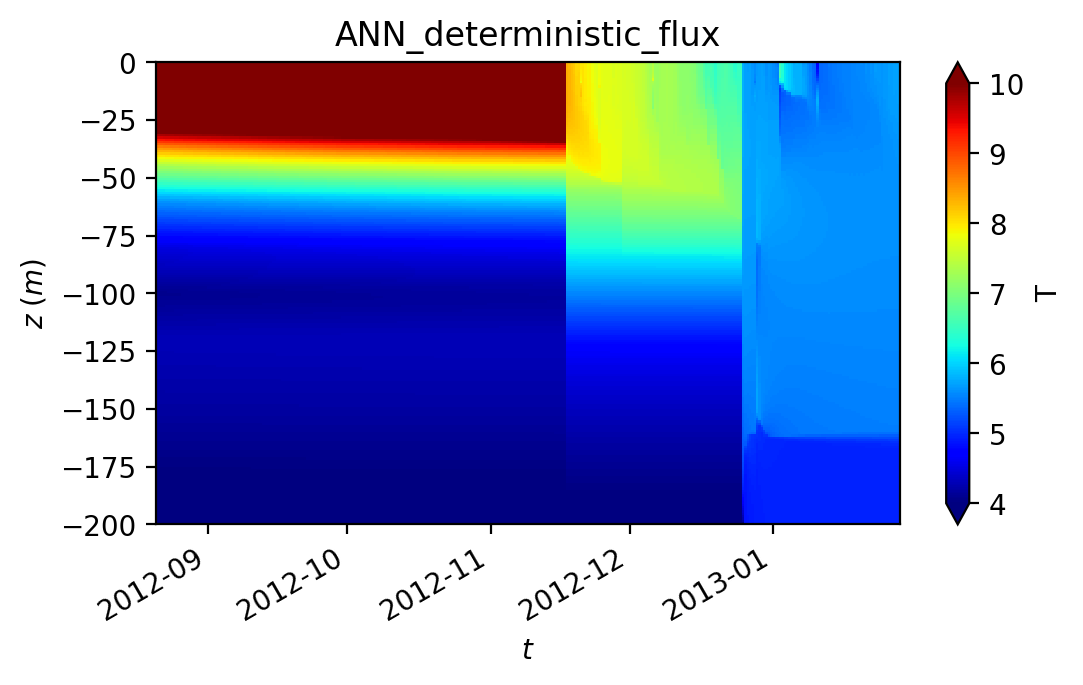

In [44]:
# filename = '/home/jw8736/test-gotm/ensem/2012-03-21_2012-05-20/out_ann_mean'
filename = '/home/jw8736/test-gotm/ensem/2012-08-21_2013-01-10/out_ann_mean'
ds_mean = read(filename, n1, n2, start_date)

plt.figure(figsize=[6,3], dpi=200)
ds_mean.T.plot(x='t', cmap='jet', vmin=4, vmax=10)
plt.title('ANN_deterministic_flux')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

Text(0.5, 0, '$t$')

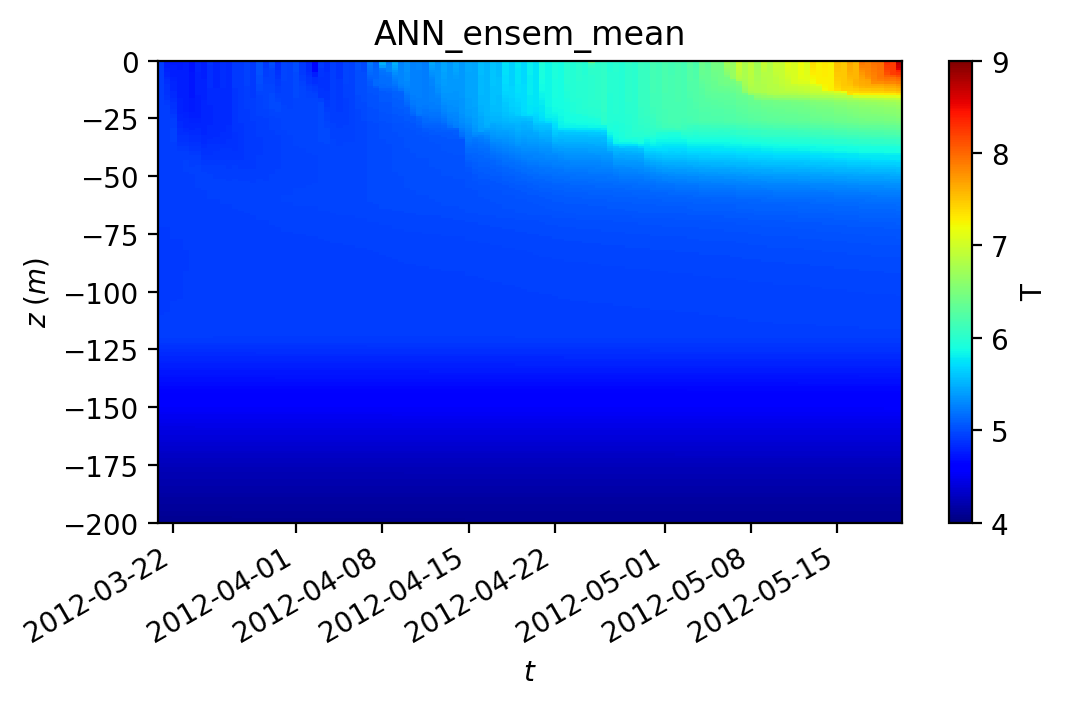

In [12]:
filename = '/home/jw8736/test-gotm/ensem/2012-03-21_2012-05-20/out_bulk'
ds_bulk = read(filename, n1=121, n2=200)

plt.figure(figsize=[6,3], dpi=200)
ds_bulk.T.plot(x='t', cmap='jet', vmin=4, vmax=9)
plt.title('ANN_ensem_mean')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

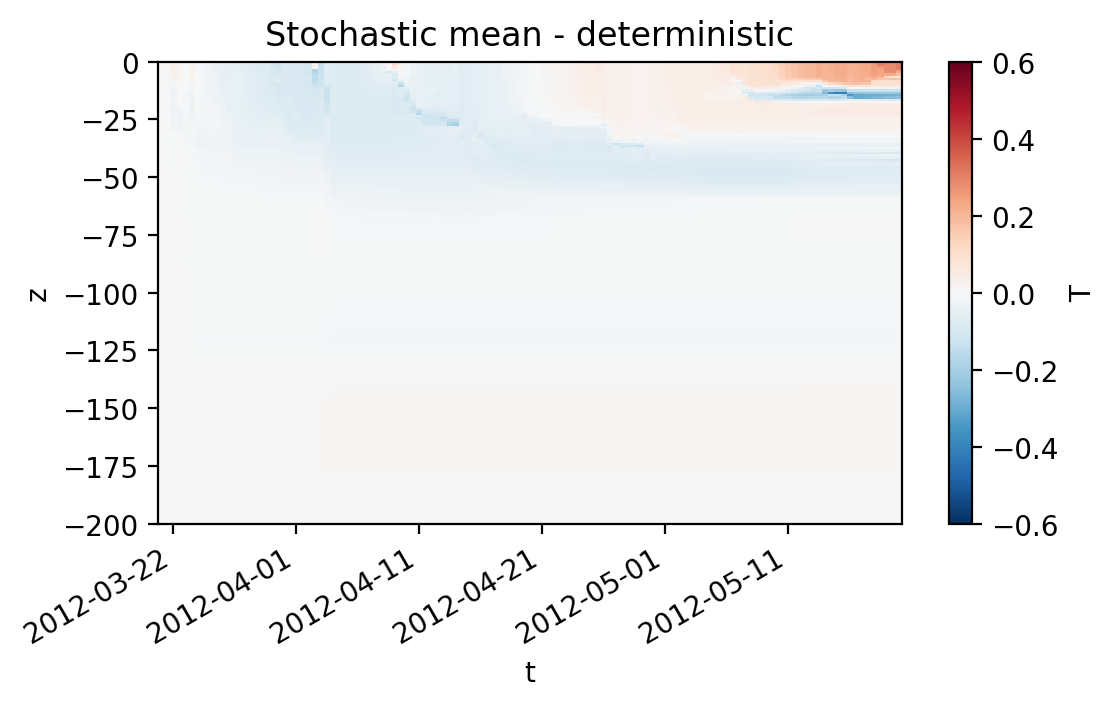

In [13]:
plt.figure(figsize=[6,3], dpi=200); ax = plt.gca()
diff = T_ensem_mean - ds_mean.T
diff.plot(x='t', cmap='RdBu_r', vmax=0.6, vmin=-0.6)
plt.title('Stochastic mean - deterministic')
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

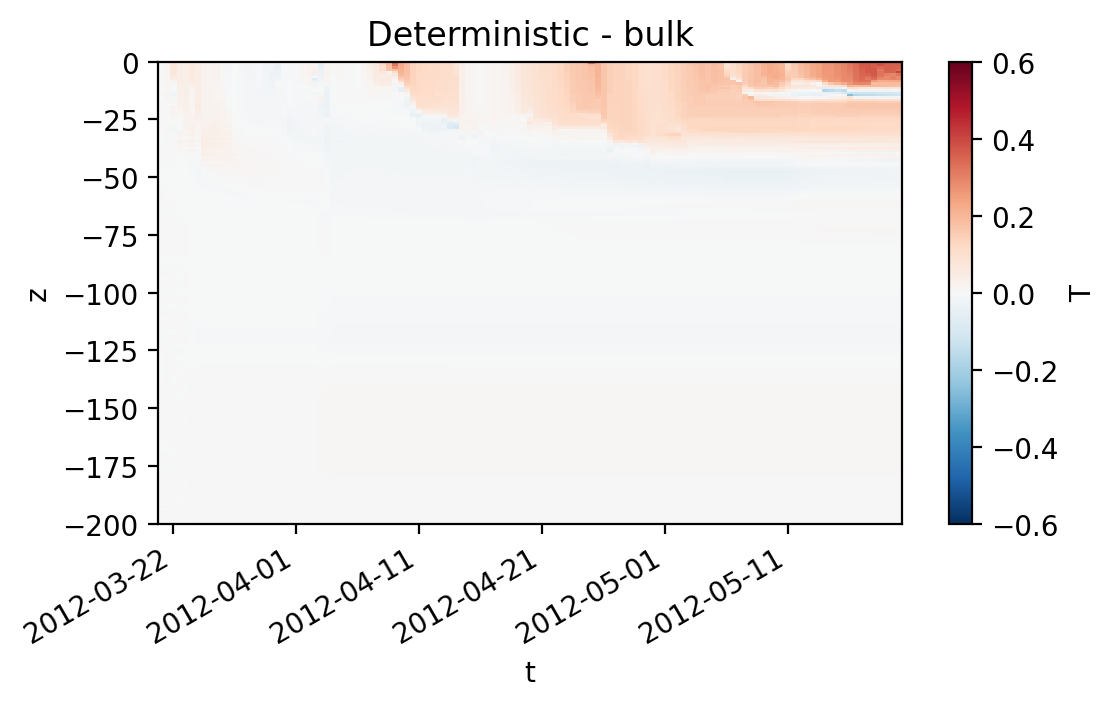

In [16]:
plt.figure(figsize=[6,3], dpi=200); ax = plt.gca()
diff = T_ensem_mean - ds_bulk.T
diff.plot(x='t', cmap='RdBu_r', vmax=0.6, vmin=-0.6)
plt.title('Stochastic mean - bulk')
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

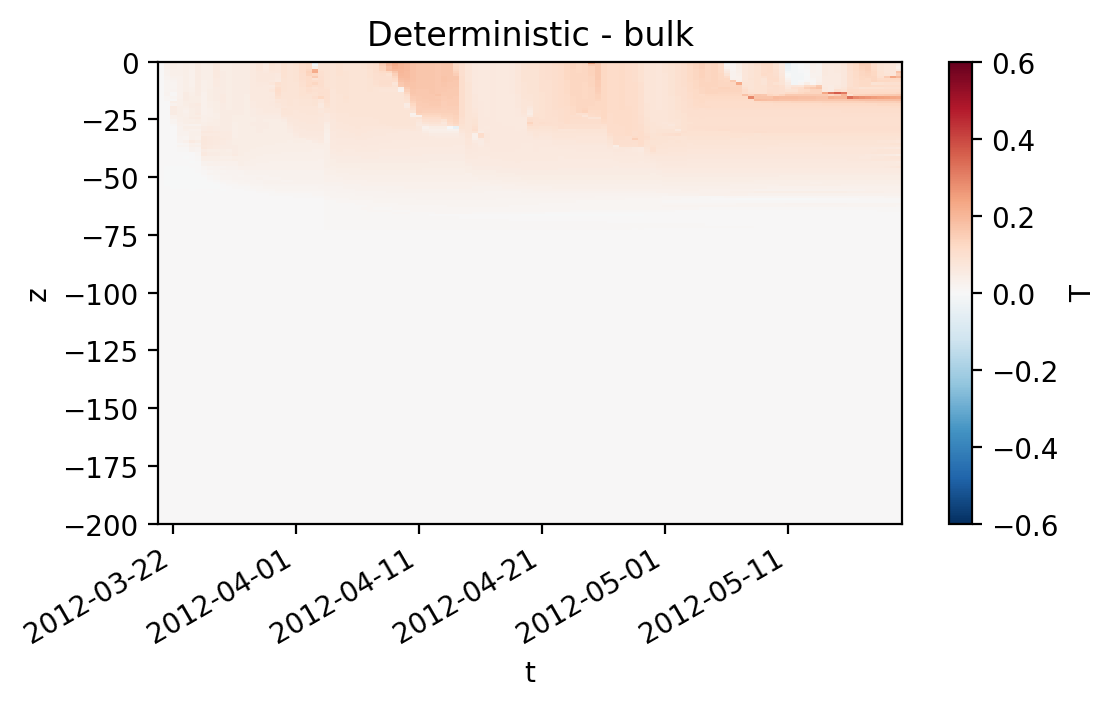

In [17]:
plt.figure(figsize=[6,3], dpi=200); ax = plt.gca()
diff = ds_mean.T - ds_bulk.T
diff.plot(x='t', cmap='RdBu_r', vmax=0.6, vmin=-0.6)
plt.title('Deterministic - bulk')
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

In [14]:
filename = '/home/jw8736/test-gotm/2012/ann/out'
df_ann = read(filename)
filename = '/home/jw8736/test-gotm/2012/bulk/out'
df_bulk = read(filename)

Text(0.5, 0, '$t$')

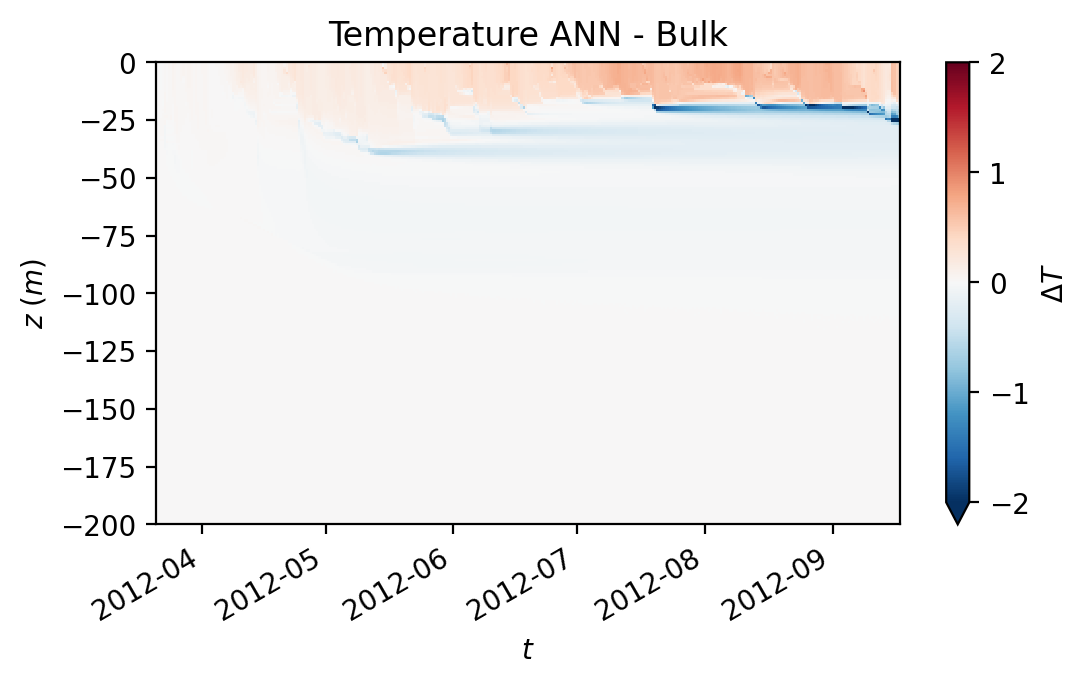

In [32]:
plt.figure(figsize=[6,3], dpi=200)
T_diff = df_ann.T - df_bulk.T
T_diff.plot(cmap='RdBu_r', vmax=2, vmin=-2, x='t', cbar_kwargs={'label':'$\Delta T$'})
plt.title('Temperature ANN - Bulk')
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

Text(0.5, 1.0, 'Ux ANN - Bulk')

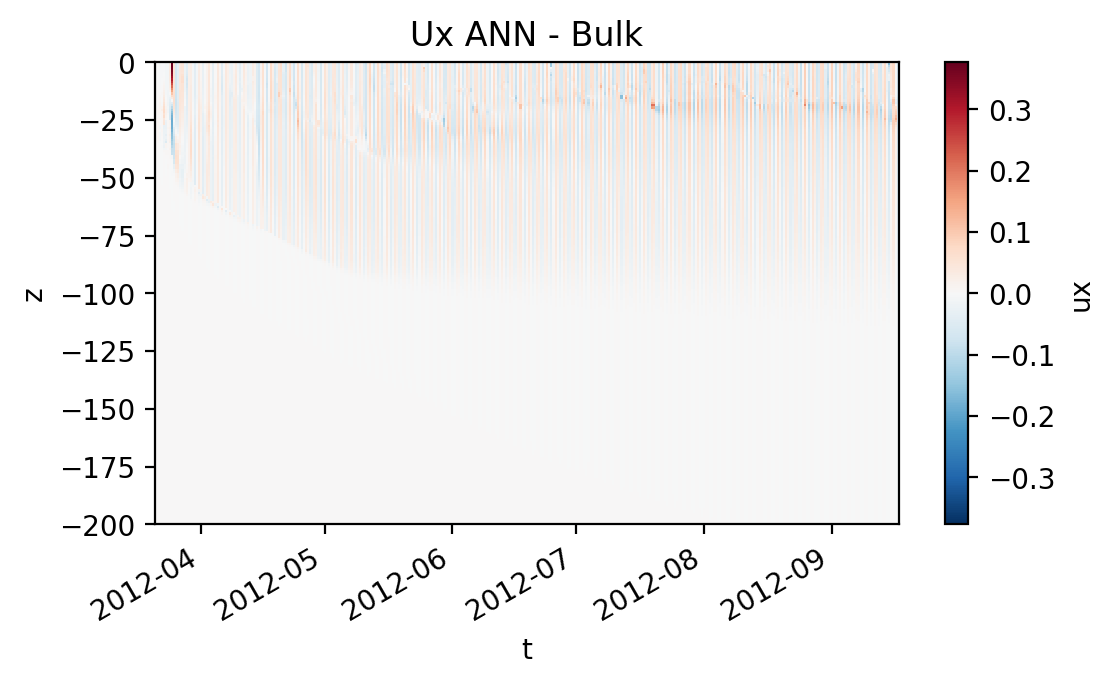

In [17]:
plt.figure(figsize=[6,3], dpi=200)
ux_diff = df_ann.ux - df_bulk.ux
ux_diff.plot(cmap='RdBu_r', x='t')
plt.title('Ux ANN - Bulk')

Text(0.5, 0, '$t$')

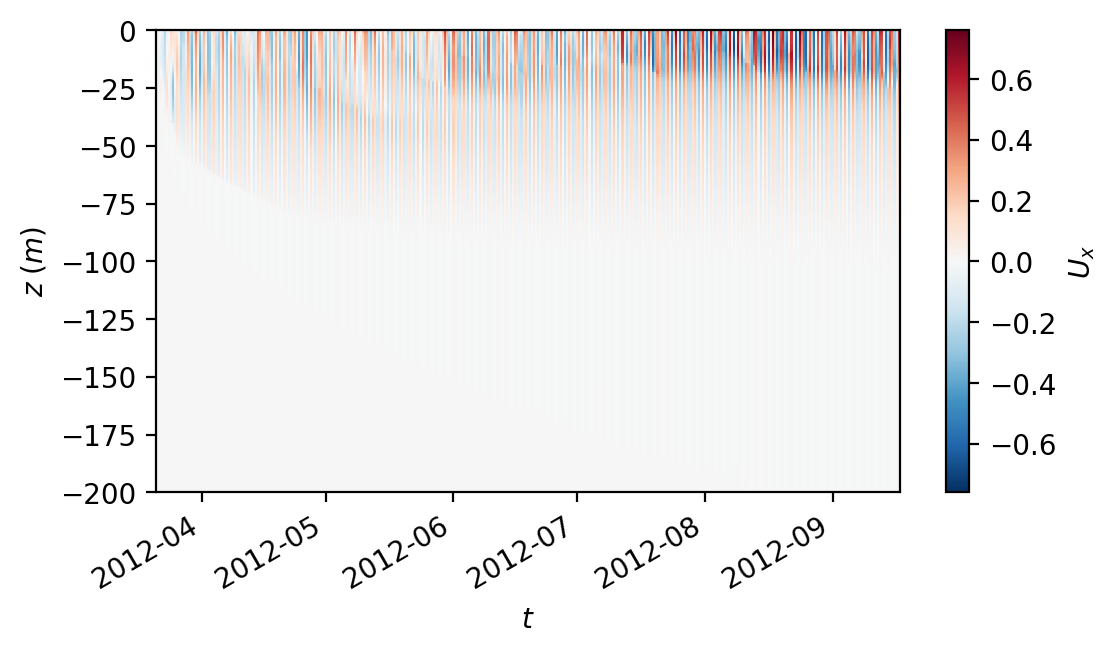

In [36]:
# ux_diff = df_ann.ux.sel(t=slice('2012-03-21','2012-06-21'))
plt.figure(figsize=[6,3], dpi=200)
ux_diff = df_ann.ux
ux_diff.plot(cmap='RdBu_r', x='t', cbar_kwargs={'label':'$U_x$'})
plt.ylabel('$z \; (m)$'); plt.xlabel('$t$')

Text(0, 0.5, '$z \\; (m)$')

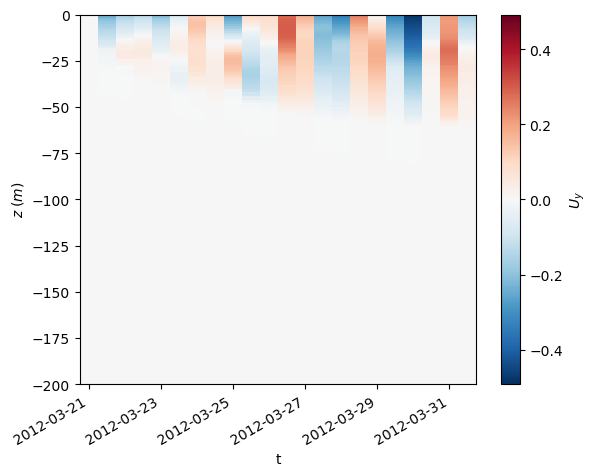

In [27]:
ux_diff = df_ann.uy.sel(t=slice('2012-03-21','2012-03-31'))
ux_diff.plot(cmap='RdBu_r', x='t', cbar_kwargs={'label':'$U_y$'})
plt.ylabel('$z \; (m)$')